In [1]:
import os
import sys
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

import glob
import random
import cv2

import datetime

from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
import torch
#import gc

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import datetime

import configparser

import numpy as np
import torch 
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
import torchvision.models as models
# import torch.autograd.profiler as profiler
from torch.backends import cudnn
from torch.autograd import Variable
import torch.optim as optim
from torch.nn import Sequential, Conv2d, ConvTranspose2d, Flatten, Linear, ReLU, LeakyReLU, Dropout, Sigmoid

import numpy as np
import pandas as pd

In [2]:

def timestamp():
    time_cur = datetime.datetime.now()
    print('datetime:',time_cur.strftime('%m/%d %H:%M'))
    stamp = time_cur.strftime('%Y%m%d%H%M')
    return(stamp)

stamp = timestamp()

datetime: 07/24 09:32


In [3]:

config = configparser.ConfigParser()

config['VQVAE'] = {'rand_seed': 765,
                   'learning_rate': 1e-3,
                   'loss_recon': "MSE", # "BCE", "MSE"
                   'optimizer': "Adam", # "Adagrad", "Adam"
                   'tuning': "model1+model2", # "model2"
                   'loader': "Resample 3 label", # "Resample 2 label", "Resample 3 label",
                   'augment_func': "Random Affine", # "Random Rotate", "Random Affine",
                   'num_code': 256,
                   'embedding_dim': 128,
                   'latent_dim': 128,
                   'res_hidden_dim': 64,
                   'cls_hidden_dim': 64,
                   'drop_rate': 0.3,
                   'beta': 0.25,
                   'cross_validation': 10,
                   'batch_size':1
                }


config.write(sys.stdout)

path_config = 'dat1/params_{}.txt'.format(stamp)
with open(path_config, 'w') as fp_config:
    config.write(fp_config)
    print("Save parameters as ", path_config)

rand_seed  = int(config['VQVAE']['rand_seed'])
random.seed(rand_seed)
np.random.seed(rand_seed)
torch.random.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

learning_rate = float(config['VQVAE']['learning_rate'])
loader = str(config['VQVAE']['loader'])
augment_func = str(config['VQVAE']['augment_func'])
loss_recon = str(config['VQVAE']['loss_recon'])
optimizer = str(config['VQVAE']['optimizer'])
tuning = str(config['VQVAE']['tuning'])

num_code = int(config['VQVAE']['num_code'])
embedding_dim = int(config['VQVAE']['embedding_dim'])
latent_dim = int(config['VQVAE']['latent_dim'])
res_hidden_dim = int(config['VQVAE']['res_hidden_dim'])

beta = float(config['VQVAE']['beta'])

drop_rate = float(config['VQVAE']['drop_rate'])
cls_hidden_dim = int(config['VQVAE']['cls_hidden_dim'])

cross_validation = int(config['VQVAE']['cross_validation'])
batch_size=int(config['VQVAE']['batch_size'])

[VQVAE]
rand_seed = 765
learning_rate = 0.001
loss_recon = MSE
optimizer = Adam
tuning = model1+model2
loader = Resample 3 label
augment_func = Random Affine
num_code = 256
embedding_dim = 128
latent_dim = 128
res_hidden_dim = 64
cls_hidden_dim = 64
drop_rate = 0.3
beta = 0.25
cross_validation = 10
batch_size = 1

Save parameters as  dat1/params_202307240932.txt


In [4]:
diagnosis1 = pd.read_csv("data/sample.csv")
diagnosis1.columns=['胸部Ｘ線番号', '胸部所見判定[コード]', '胸部所見判定[名称]', '胸膜肥厚', '側弯', '気胸', '胸部部位コード1',
       '胸部部位名称1', '胸部所見コード1', '胸部所見名称1', '胸部部位コード2', '胸部部位名称2', '胸部所見コード2',
       '胸部所見名称2', '胸部部位コード3', '胸部部位名称3', '胸部所見コード3', '胸部所見名称3', '胸部部位コード4',
       '胸部部位名称4', '胸部所見コード4', '胸部所見名称4']

diagnosis2 = pd.read_csv("data/test_sample.csv")
pix_all = np.load("data/sample.npy")
pix_20210708 = np.load("data/test_sample.npy")
print(diagnosis1.shape)
print(pix_all.shape)
n_sample, ny, nx = pix_all.shape


(12, 22)
(12, 512, 512)


In [5]:
target_pleural = (diagnosis1["胸膜肥厚"]=="有").to_numpy().astype(int)
target_scoliosis = (diagnosis1["側弯"]=="有").to_numpy().astype(int)

print(np.sum(target_pleural))
print(np.sum(target_scoliosis))

4
4


In [6]:
target_type = "both"

if(target_type=="pleural"):
    print("pleural")
    target_all = np.zeros((len(diagnosis1),2),dtype=np.uint8)
    target_all[target_pleural==0,0] = 1
    target_all[target_pleural==1,1] = 1

    target_1k = np.zeros((n_sample,2),dtype=np.uint8)
    target_1k[:,0][diagnosis2["胸膜肥厚"]=="No"] = 1
    target_1k[:,1][diagnosis2["胸膜肥厚"]!="No"] = 1 # R, L, RL

if(target_type=="scoliosis"):
    print("scoliosis")
    target_all = np.zeros((len(diagnosis1),2),dtype=np.uint8)
    target_all[target_scoliosis==0,0] = 1
    target_all[target_scoliosis==1,1] = 1

    target_1k = np.zeros((n_sample,2),dtype=np.uint8)
    target_1k[:,0][diagnosis2["側弯"]=="No"] = 1
    target_1k[:,1][diagnosis2["側弯"]=="有"] = 1

if(target_type=="both"):
    print("both")
    target_all = np.zeros((len(diagnosis1),2),dtype=np.uint8)
    target_all[:,0][target_pleural==1] = 1
    target_all[:,1][target_scoliosis==1] = 1

    target_1k = np.zeros((n_sample,2),dtype=np.uint8)
    target_1k[:,0][diagnosis2["胸膜肥厚"]!="No"] = 1 # R, L, RL
    target_1k[:,1][diagnosis2["側弯"]=="有"] = 1

both


# Cross Validation

Divide train and test by 9:1

(actually test may not be used for )

In [7]:
idx_trn = np.arange(n_sample)
np.random.shuffle(idx_trn)
idx_cv10 = np.array_split(idx_trn, 10)
idx_val = np.sort(idx_cv10[0])
idx_trn = np.sort(np.setdiff1d(idx_trn, idx_val))
print(len(idx_val))
print(len(idx_trn))

2
10


In [8]:

class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(dim, res_h_dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, dim, kernel_size=1, stride=1, padding=0, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        return x


class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, h_dim, res_h_dim, n_res_layers=2):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(h_dim, res_h_dim)]*n_res_layers)

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x

class Encoder(nn.Module):
    """
    This is the q_theta (z|x) network. Given a data sample x q_theta 
    maps to the latent space x -> z.

    For a VQ VAE, q_theta outputs parameters of a categorical distribution.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim, embedding_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim, kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel,stride=stride, padding=1),
            ResidualStack(h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, embedding_dim, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        return self.conv_stack(x)


class Decoder(nn.Module):
    """
    This is the p_phi (x|z) network. Given a latent sample z p_phi 
    maps back to the original space z -> x.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, embedding_dim, h_dim, n_res_layers, res_h_dim, out_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            ConvTranspose2d(embedding_dim, h_dim, kernel_size=1, stride=1, padding=0),
            ResidualStack(h_dim, res_h_dim, n_res_layers),
            ConvTranspose2d(h_dim, h_dim, kernel_size=kernel, stride=stride, padding=1),
            ReLU(),
            ConvTranspose2d(h_dim, h_dim, kernel_size=kernel, stride=stride, padding=1),
            ReLU(),
            ConvTranspose2d(h_dim, 1, kernel_size=kernel, stride=stride, padding=1),
            Sigmoid(),
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)

class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.

    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, n_e, e_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta
        
        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        #weight.shape--->(n_e,e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete 
        one-hot vector that is the index of the closest embedding vector e_j

        z (continuous) -> z_q (discrete)

        z.shape = (batch, channel, height, width)

        quantization pipeline:

            1. get encoder input (B,C,H,W)
            2. flatten input to (B*H*W,C)

        """
        # reshape z -> (batch, height, width, channel) and flatten
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.e_dim)
        
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z
        #shape----->[n,n_e]
        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())
        

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        
        #-------->[n,n_e]
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).cuda()

        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta*torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # reshape back to match original input shape
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, min_encodings, min_encoding_indices

class VQVAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        
        super(VQVAE, self).__init__()

        self.encoder = Encoder(1, h_dim, n_res_layers, res_h_dim, embedding_dim)
        self.vector_quantization = VectorQuantizer(n_embeddings, embedding_dim, beta)
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim, 1)

    def forward(self, xxx, verbose=False):
        zzz = self.encoder(xxx)
        embedding_loss, zzz_q, perplexity, _, _ = self.vector_quantization(zzz)
        xxx_out = self.decoder(zzz_q)

        if verbose:
            print('original data shape:', x.shape)
            print('encoded data shape:', z_e.shape)
            print('recon data shape:', x_hat.shape)
            assert False

        return embedding_loss, zzz_q, xxx_out, perplexity

class Classifier(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            Conv2d(in_dim, h_dim*2, kernel_size=3, stride=2, padding=1),
            LeakyReLU(0.1),
            Dropout(drop_rate),
            Conv2d(h_dim*2, h_dim, kernel_size=3, stride=2, padding=1),
            LeakyReLU(0.1),
            Dropout(drop_rate),
            Flatten(),
            Linear(h_dim*8*8, 1280),
            LeakyReLU(0.1),
            Dropout(drop_rate),
            Linear(1280, 512),
            LeakyReLU(0.1),
            Dropout(drop_rate),
            Linear(512, 128),
            LeakyReLU(0.1),
            Dropout(drop_rate),
            Linear(128, 2),
        )

    def forward(self, xxx):
        return self.classifier(xxx)

        

In [9]:
model1 = VQVAE(latent_dim, res_hidden_dim, 2, num_code, embedding_dim, beta).cuda()


In [10]:
summary(model1.vector_quantization, (batch_size, embedding_dim, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VectorQuantizer                          --                        --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.52
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.52

In [11]:
summary(model1.decoder, (batch_size, embedding_dim, 32 ,32))

Layer (type:depth-idx)                        Output Shape              Param #
Decoder                                       --                        --
├─Sequential: 1                               --                        --
│    └─ResidualStack: 2                       --                        --
│    │    └─ModuleList: 3-1                   --                        81,920
├─Sequential: 1-1                             [1, 1, 256, 256]          --
│    └─ConvTranspose2d: 2-1                   [1, 128, 32, 32]          16,512
│    └─ResidualStack: 2-2                     [1, 128, 32, 32]          --
│    └─ConvTranspose2d: 2-3                   [1, 128, 64, 64]          262,272
│    └─ReLU: 2-4                              [1, 128, 64, 64]          --
│    └─ConvTranspose2d: 2-5                   [1, 128, 128, 128]        262,272
│    └─ReLU: 2-6                              [1, 128, 128, 128]        --
│    └─ConvTranspose2d: 2-7                   [1, 1, 256, 256]          2,049

In [12]:
if(optimizer=="Adagrad"):
    optim1 = optim.Adagrad(model1.parameters(), lr=learning_rate)
if(optimizer=="Adam"):
    optim1 = optim.Adam(model1.parameters(), lr=learning_rate, amsgrad=True)

LossMSE = torch.nn.MSELoss()
LossBCE = torch.nn.BCELoss()
print(loss_recon)
if(loss_recon=="MSE"):
    LossRecon = LossMSE
if(loss_recon=="BCE"):
    LossRecon = LossBCE

LossCLS = torch.nn.BCEWithLogitsLoss()

MSE


In [13]:

class HistDict():
    def __init__(self, keys):
        """
        Class that stores the model's evaluation values in a dictionary type.

        Args:
            keys (list): List of keys to represent the categories.

        Returns:
            None
        """
        self.values = {}
        for kk in keys:
            self.values[kk] = []
        self.keys = keys
        
    def append(self, dict_hist):
        """
        Append values from the input dictionary to the corresponding keys in the HistDict.

        Args:
            dict_hist (dict): Dictionary containing values to be appended.

        Returns:
            None
        """
        for kk in dict_hist.keys():
            self.values[kk].append(dict_hist[kk])
            
    def mean(self, keys=None):
        """
        Calculate the mean of the values for the specified keys or all keys.

        Args:
            keys (list, optional): List of keys for which to calculate the mean. 
                If None, the mean will be calculated for all keys.

        Returns:
            dict: A dictionary containing the means for each key.
        """
        if(keys is None):
            keys = self.keys
        mm = {}
        for kk in keys: 
            mm[kk] = np.round(np.mean(self.values[kk]), 6)
        return mm

    def __getitem__(self, key):
        """
        Get values for the specified key.

        Args:
            key (str): The key for which to retrieve the values.

        Returns:
            list: A list of values corresponding to the key.
        """
        return self.values[key]
    
    def to_str(self, keys=None):
        """
        Convert the HistDict values to a string representation.

        Args:
            keys (list, optional): List of keys for which to create the string representation. 
                If None, the string will be created for all keys.

        Returns:
            list: A list of strings representing the values for each key.
        """
        if(keys is None):
            keys = self.keys
        sss = [kk + ":" + str(self.values[kk]) for kk in keys]
        return sss

    def DataFrame(self):
        """
        Create a pandas DataFrame from the HistDict values.

        Args:
            None

        Returns:
            pandas.DataFrame: A DataFrame with the HistDict values.
        """
        tmp = pd.DataFrame.from_dict(self.values)
        return tmp



In [14]:

def make_batch_list(idx, batch_size=100, n_batch=None, shuffle=True):
    """
    Creates a list of batches from given indices.

    Args:
        idx (array-like): The indices to be divided into batches.
        batch_size (int): The desired batch size (default: 100).
        n_batch (int, optional): The number of batches to create. If not provided, it is calculated based on idx and batch_size.
        shuffle (bool): Whether to shuffle the indices before creating batches (default: True).

    Returns:
        batch_list (list): A list of batches containing the divided indices.

    """
    # Calculate the number of batches if not provided
    if n_batch is None:
        n_batch = len(idx) // batch_size

    # Shuffle the indices if requested
    if shuffle:
        np.random.shuffle(idx)

    # Divide the indices into batches
    batch_list = np.array_split(idx, n_batch)

    return batch_list


In [15]:
def make_batch_list_resample2(idx, label_1, label_2, batch_size):
    n_batch = len(idx) // batch_size

    jjj_1 = np.where(label_1[idx]==1)[0]
    jjj_2 = np.where(label_2[idx]==1)[0]
    n_1 = len(jjj_1)
    n_2 = len(jjj_2)
    if(n_1==0 or n_2==0):
        print("unsufficient samples n_1, n_2",n_1, n_2)
        return(np.array_split(idx, n_batch))
    
    batch_list = []
    for aa in range(n_batch):
        jjj = np.concatenate((np.random.choice(jjj_1, size=batch_size//2, replace=True),
                              np.random.choice(jjj_2, size=batch_size//2, replace=True),
                              ))
        batch_list.append(idx[jjj])
    return(batch_list)

In [16]:
def make_batch_list_resample3(idx, label_1, label_2, batch_size):
    n_batch = len(idx) // batch_size

    jjj_1 = np.where(label_1[idx]==1)[0]
    jjj_2 = np.where(label_2[idx]==1)[0]
    jjj_0 = np.where(np.logical_and(label_1[idx]==0, label_2[idx]==0))[0]
    n_1 = len(jjj_1)
    n_2 = len(jjj_2)
    n_0 = len(jjj_0)
    if(n_0==0 or n_1==0 or n_2==0):
        print("unsufficient samples", n_0, n_1, n_2)
        return(np.array_split(idx, n_batch))
    
    batch_list = []
    for aa in range(n_batch):
        jjj = np.concatenate( (np.random.choice(jjj_0, size=batch_size//3, replace=True),
                               np.random.choice(jjj_1, size=batch_size//3, replace=True),
                               np.random.choice(jjj_2, size=batch_size//3, replace=True),
                              )
                            )
        batch_list.append(idx[jjj])
    return(batch_list)

In [17]:
ToImage = transforms.ToPILImage()
ToTensor = transforms.Compose([transforms.ToTensor(),transforms.Resize(256)])
Rotate = transforms.RandomRotation(5)
RandomAffine = transforms.RandomAffine(degrees=5, translate=(0.02,0.02), scale=(0.98,1.02))

def generate_batch(idx, pix, target, augment=False):
    epsilon = 1e-8
    tmp = []
    for ii in idx:
        if(augment):
            image = ToImage(pix[ii])
            if(augment_func=="Random Rotate"):
                xxx = ToTensor(Rotate(image))
            if(augment_func=="Random Affine"):
                xxx = ToTensor(RandomAffine(image))
                
            tmp.append(xxx)
        else:
            tmp.append(ToTensor(pix[ii].reshape(ny,nx,1)))
    xxx_batch = torch.stack(tmp, dim=0)
    xxx_batch[xxx_batch <= epsilon] = epsilon
    xxx_batch[xxx_batch > 1-epsilon] = 1-epsilon
    yyy_batch = torch.FloatTensor(target[idx])
    ## yyy_batch = torch.FloatTensor(yyy[idx]).reshape((-1,1))
    return(xxx_batch.cuda(), yyy_batch.cuda())

In [18]:
batch_list = make_batch_list(idx_trn, batch_size=batch_size)

In [19]:
idx_tmp = batch_list[0]
xxx_tmp, yyy_tmp = generate_batch(idx_tmp, pix_all, target_all)

In [20]:
# torch.autograd.set_detect_anomaly(True)
loss_embedding, zzz_tmp, out_tmp, perplexity  = model1(xxx_tmp)
print(loss_embedding.item())

0.0037175947800278664


In [21]:
loss_embedding.backward()
optim1.step()
optim1.zero_grad()

In [22]:
loss_embedding, zzz_tmp, out_tmp, perplexity  = model1(xxx_tmp)

loss_recon = LossRecon(out_tmp, xxx_tmp)

print(loss_recon.item())
loss_recon.backward()
optim1.step()
optim1.zero_grad()

0.06736995279788971


# CV10

In [23]:
model1 = VQVAE(latent_dim, res_hidden_dim, 2, num_code, embedding_dim, beta).cuda()
model2 = Classifier(embedding_dim, cls_hidden_dim, 2).cuda()


In [24]:

path_save = "dat1/model1_{}_0.ckpt".format(stamp)
torch.save(model1.state_dict(), path_save)
print("Save the initial model1",path_save)

path_save = "dat1/model2_{}_0.ckpt".format(stamp)
torch.save(model2.state_dict(), path_save)
print("Save the initial model2",path_save)


Save the initial model1 dat1/model1_202307240932_0.ckpt
Save the initial model2 dat1/model2_202307240932_0.ckpt


In [25]:
def train1(t_epoch, t_log):
    """
    Trains the model for a specified number of epochs.

    Args:
        t_epoch (int): The number of epochs to train.
        t_log (int): The interval for logging the training progress.

    Returns:
        hist_tt (HistDict): The history of training and validation metrics.
                            training - loss_trn : history of total Loss value in training phase.
                                       loss_embedding : history of embedding Loss value in training phase.
                                       loss_recon : history of reconstraction Loss value in training phase.
                                       perplexity : history of perplexity of vectors retrieved from within the codebook.
                                       
                            validation - loss_val : history of total Loss value in validation phase.
    """
    
    timestamp()
    
    t0 = 0

    key_loss_trn = ["loss_trn", "loss_embedding", "loss_recon", "perplexity"]
    key_loss_val = ["loss_val"]
    hist1_tt = HistDict(["tt"]+key_loss_trn+key_loss_val)

    with tqdm(range(t0, t0+t_epoch)) as bar_epoch:
        for tt in bar_epoch:

            ### train
            hist_batch = HistDict(key_loss_trn)
            model1.train()
            batch_list = make_batch_list(idx_trn, batch_size=batch_size, shuffle=True)
            with tqdm(batch_list, leave=False) as pbar:
                for idx_tmp in pbar:
                    pbar.set_description("Train")
                    xxx_tmp, yyy_tmp = generate_batch(idx_tmp, pix_all, target_all, augment=True)
                    loss_embedding, zzz_tmp, out_tmp, perplexity = model1(xxx_tmp)
                    loss_recon = LossRecon(out_tmp, xxx_tmp)
                    loss_tmp = loss_embedding + loss_recon
                    optim1.zero_grad()
                    loss_tmp.backward()
                    optim1.step()

                    hist_batch.append({"loss_trn":loss_tmp.item(), 
                                       "loss_embedding":loss_embedding.item(), 
                                       "loss_recon":loss_recon.item(), 
                                       "perplexity":perplexity.item()})
            hist_trn = hist_batch.mean()
            hist1_tt.append({"tt":tt})
            hist1_tt.append(hist_trn)

            ### test
            hist_batch = HistDict(key_loss_val)
            with torch.no_grad():
                model1.eval()
                batch_list = make_batch_list(idx_val, batch_size=batch_size, shuffle=False)
                with tqdm(batch_list, leave=False) as pbar:
                    for idx_tmp in pbar:
                        pbar.set_description("Test")
                        xxx_tmp, yyy_tmp = generate_batch(idx_tmp, pix_all, target_all, augment=False)
                        loss_embedding, zzz_tmp, out_tmp, perplexity = model1(xxx_tmp)
                        loss_recon = LossRecon(out_tmp, xxx_tmp)
                        loss_tmp = loss_embedding + loss_recon
                        hist_batch.append({"loss_val":loss_tmp.item()}) 
            hist_val = hist_batch.mean()
            hist1_tt.append(hist_val)

            bar_epoch.set_postfix(trn=hist_trn["loss_trn"],val=hist_val["loss_val"])

            if((tt+1) % t_log==0):
                print(tt+1,hist_trn["loss_trn"],hist_val["loss_val"])
    t0 += t_epoch
    timestamp()

    plt.plot(hist1_tt["tt"], hist1_tt["loss_trn"])
    plt.plot(hist1_tt["tt"], hist1_tt["loss_val"])
    plt.show()
    return(hist1_tt)


In [33]:
def train2(t_epoch, t_log):
    timestamp()

    t0 = 0

    key_loss_trn = ["loss_trn", "cls_trn"]
    key_loss_val = ["loss_val", "cls_val"]
    #key_loss_1k = ["loss_1k", "cls_1k"]

    hist2_tt = HistDict(["tt"]+key_loss_trn+key_loss_val)
    with tqdm(range(t0, t0+t_epoch)) as bar_epoch:
        for tt in bar_epoch:
            ### train
            hist_batch = HistDict(key_loss_trn)
            model1.train()
            model2.train()
            batch_list = make_batch_list(idx_trn, batch_size=batch_size, shuffle=True)
            #print(idx_trn)
            with tqdm(batch_list, leave=False) as pbar:
                for idx_tmp in pbar:
                    pbar.set_description("Train")
                    xxx_tmp, yyy_tmp = generate_batch(idx_tmp, pix_all, target_all, augment=True)
                    loss_embedding, zzz_tmp, out_tmp, perplexity = model1(xxx_tmp)
                    loss_recon = LossRecon(out_tmp, xxx_tmp)
                    #print(zzz_tmp.shape)
                    prd_tmp = model2(zzz_tmp)
                    loss_cls = LossCLS(prd_tmp, yyy_tmp)

                    loss_tmp = loss_embedding + loss_recon + loss_cls

                    optim2.zero_grad()
                    loss_tmp.backward()
                    optim2.step()

                    hist_batch.append({"loss_trn":loss_tmp.item(), 
                                       "cls_trn":loss_cls.item(), 
                                      })
            hist_trn = hist_batch.mean()
            hist2_tt.append({"tt":tt})
            hist2_tt.append(hist_trn)

            ### test
            hist_batch = HistDict(key_loss_val)
            with torch.no_grad():
                model1.eval()
                model2.eval()
                batch_list = make_batch_list(idx_val, batch_size=batch_size, shuffle=True)
                with tqdm(batch_list, leave=False) as pbar:
                    for idx_tmp in pbar:
                        pbar.set_description("Test")
                        xxx_tmp, yyy_tmp = generate_batch(idx_tmp, pix_all, target_all, augment=False)
                        loss_embedding, zzz_tmp, out_tmp, perplexity = model1(xxx_tmp)
                        loss_recon = LossRecon(out_tmp, xxx_tmp)

                        prd_tmp = model2(zzz_tmp)
                        loss_cls = LossCLS(prd_tmp, yyy_tmp)

                        loss_tmp = loss_embedding + loss_recon + loss_cls

                        hist_batch.append({"loss_val":loss_tmp.item(),
                                           "cls_val":loss_cls.item(),
                                          })
            hist_val = hist_batch.mean()
            hist2_tt.append(hist_val)
    plt.plot(hist2_tt["tt"], hist2_tt["cls_trn"])
    plt.plot(hist2_tt["tt"], hist2_tt["cls_val"])
    #plt.plot(hist2_tt["tt"], hist2_tt["cls_1k"])
    plt.show()

    timestamp()
    return(hist2_tt)



datetime: 07/24 09:41


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3 0.095671 0.155067


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

6 0.046079 0.229141


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

9 0.011743 0.009159


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

12 0.008074 0.006483


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

15 0.005212 0.004093
datetime: 07/24 09:41


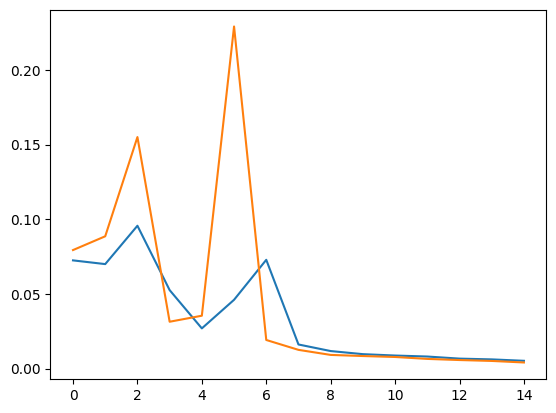

Save model dat1/model1_202307240932_15_cv0.ckpt
Save hist dat1/hist_202307240932_15_cv0.ckpt
fine tuning
datetime: 07/24 09:41


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

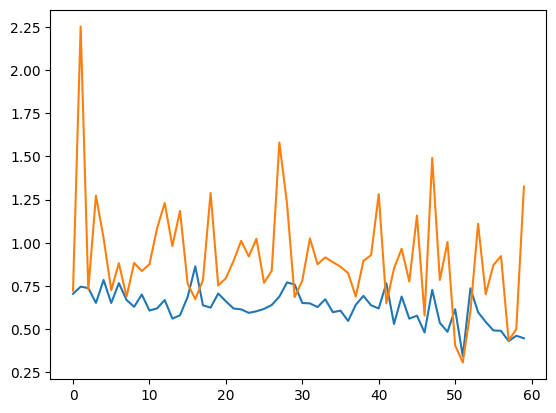

datetime: 07/24 09:42
Save model dat1/model1_202307240932_75_cv0.ckpt
Save model dat1/model2_202307240932_60_cv0.ckpt
Save hist dat1/hist2_202307240932_60_cv0.ckpt
datetime: 07/24 09:42


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

3 0.273573 0.055677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

6 0.025155 0.017813


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

9 0.061964 0.028602


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

12 0.011257 0.007807


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

15 0.009123 0.007149
datetime: 07/24 09:42


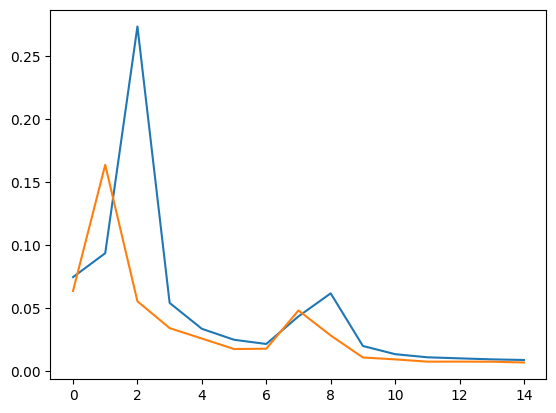

Save model dat1/model1_202307240932_15_cv1.ckpt
Save hist dat1/hist_202307240932_15_cv1.ckpt
fine tuning
datetime: 07/24 09:42


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

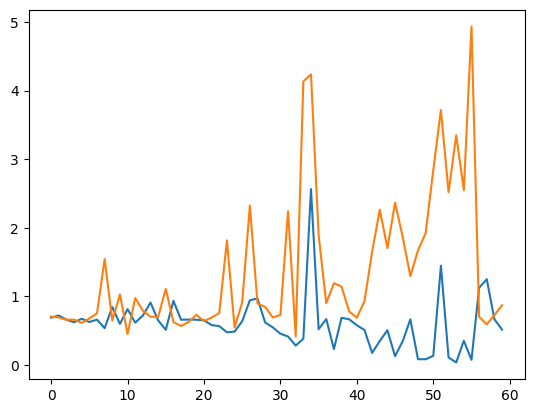

datetime: 07/24 09:42
Save model dat1/model1_202307240932_75_cv1.ckpt
Save model dat1/model2_202307240932_60_cv1.ckpt
Save hist dat1/hist2_202307240932_60_cv1.ckpt
datetime: 07/24 09:42


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.548099 0.137681


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.056954 0.056957


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.034422 0.016146


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12 0.013686 0.010423


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15 0.011946 0.010736
datetime: 07/24 09:42


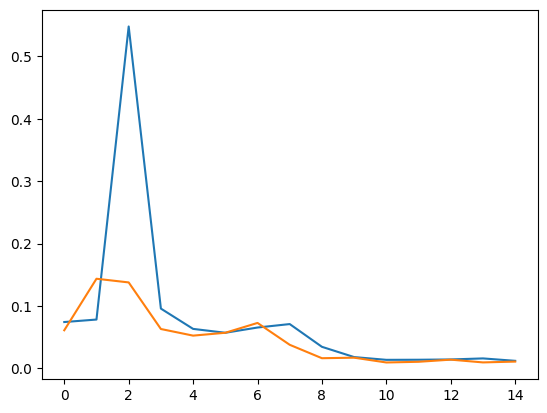

Save model dat1/model1_202307240932_15_cv2.ckpt
Save hist dat1/hist_202307240932_15_cv2.ckpt
fine tuning
datetime: 07/24 09:42


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

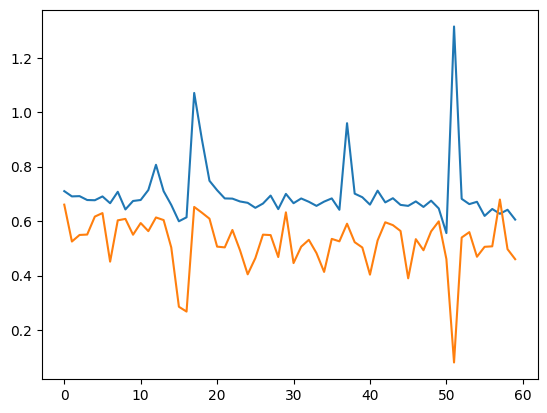

datetime: 07/24 09:43
Save model dat1/model1_202307240932_75_cv2.ckpt
Save model dat1/model2_202307240932_60_cv2.ckpt
Save hist dat1/hist2_202307240932_60_cv2.ckpt
datetime: 07/24 09:43


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.108839 0.041646


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.063536 0.088703


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.01379 0.007789


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12 0.007772 0.005606


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15 0.005534 0.003799
datetime: 07/24 09:43


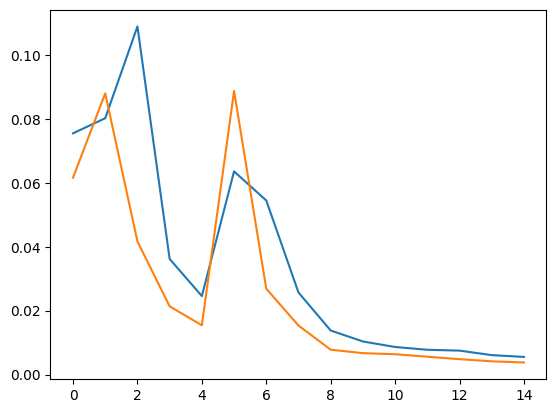

Save model dat1/model1_202307240932_15_cv3.ckpt
Save hist dat1/hist_202307240932_15_cv3.ckpt
fine tuning
datetime: 07/24 09:43


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

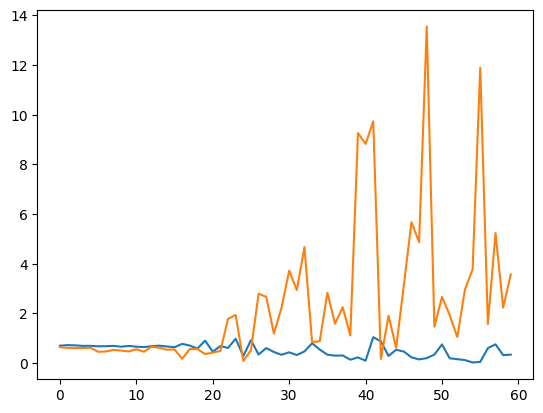

datetime: 07/24 09:43
Save model dat1/model1_202307240932_75_cv3.ckpt
Save model dat1/model2_202307240932_60_cv3.ckpt
Save hist dat1/hist2_202307240932_60_cv3.ckpt
datetime: 07/24 09:43


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.123456 0.023003


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.017182 0.012748


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.012302 0.010116


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12 0.00997 0.007358


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15 0.005572 0.004894
datetime: 07/24 09:44


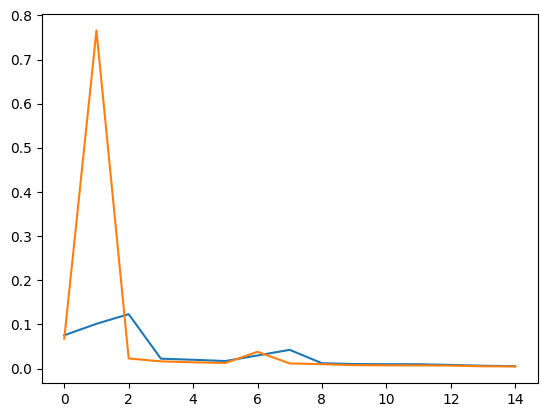

Save model dat1/model1_202307240932_15_cv4.ckpt
Save hist dat1/hist_202307240932_15_cv4.ckpt
fine tuning
datetime: 07/24 09:44


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

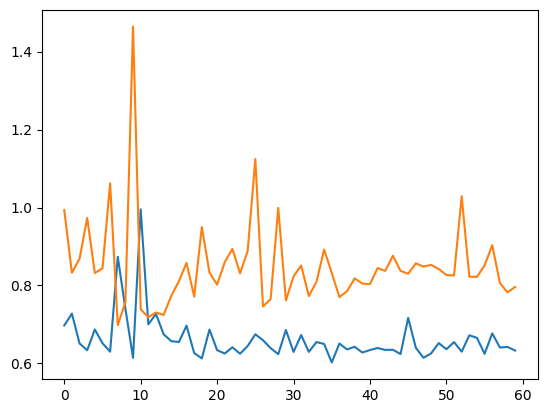

datetime: 07/24 09:44
Save model dat1/model1_202307240932_75_cv4.ckpt
Save model dat1/model2_202307240932_60_cv4.ckpt
Save hist dat1/hist2_202307240932_60_cv4.ckpt
datetime: 07/24 09:44


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.074377 0.078303


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.071711 0.078299


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.070288 0.077407


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12 0.069242 0.074647


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15 0.063977 0.072088
datetime: 07/24 09:44


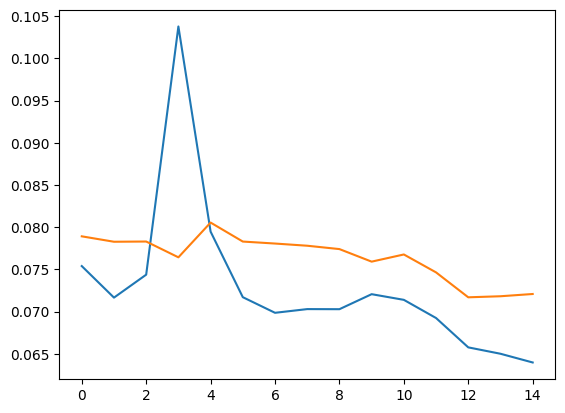

Save model dat1/model1_202307240932_15_cv5.ckpt
Save hist dat1/hist_202307240932_15_cv5.ckpt
fine tuning
datetime: 07/24 09:44


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

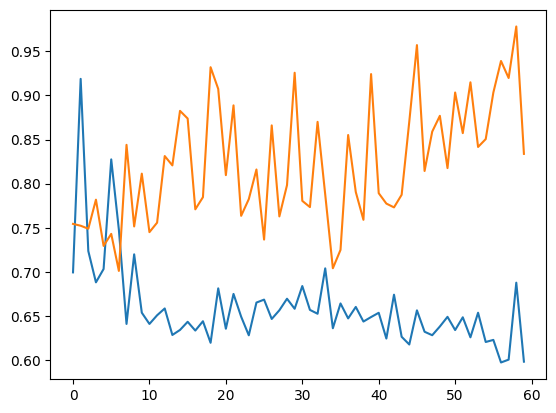

datetime: 07/24 09:45
Save model dat1/model1_202307240932_75_cv5.ckpt
Save model dat1/model2_202307240932_60_cv5.ckpt
Save hist dat1/hist2_202307240932_60_cv5.ckpt
datetime: 07/24 09:45


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.670841 0.168062


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.030227 0.02017


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.026737 0.012633


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12 0.011763 0.01012


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15 0.009361 0.007846
datetime: 07/24 09:45


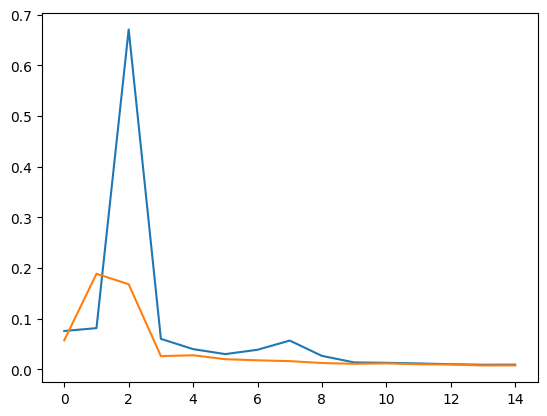

Save model dat1/model1_202307240932_15_cv6.ckpt
Save hist dat1/hist_202307240932_15_cv6.ckpt
fine tuning
datetime: 07/24 09:45


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

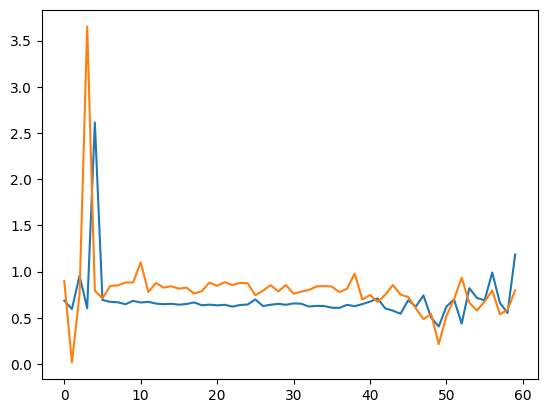

datetime: 07/24 09:45
Save model dat1/model1_202307240932_75_cv6.ckpt
Save model dat1/model2_202307240932_60_cv6.ckpt
Save hist dat1/hist2_202307240932_60_cv6.ckpt
datetime: 07/24 09:45


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.190276 0.055293


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.030256 0.022298


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.012563 0.007998


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12 0.007665 0.006392


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15 0.005365 0.004228
datetime: 07/24 09:45


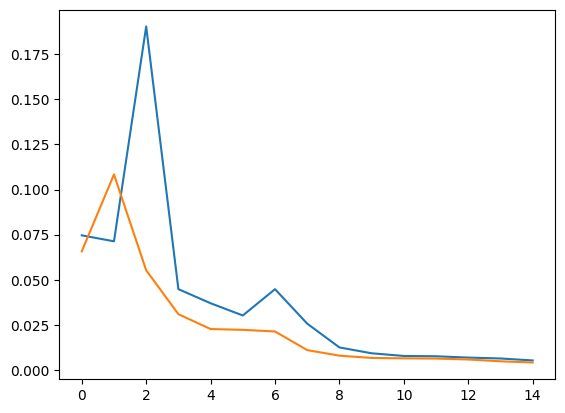

Save model dat1/model1_202307240932_15_cv7.ckpt
Save hist dat1/hist_202307240932_15_cv7.ckpt
fine tuning
datetime: 07/24 09:45


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

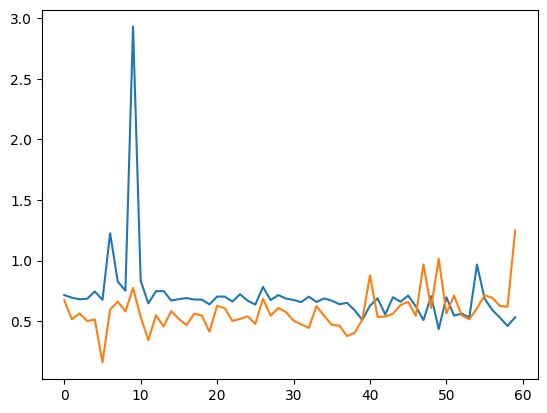

datetime: 07/24 09:46
Save model dat1/model1_202307240932_75_cv7.ckpt
Save model dat1/model2_202307240932_60_cv7.ckpt
Save hist dat1/hist2_202307240932_60_cv7.ckpt
datetime: 07/24 09:46


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.199536 0.090438


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.028171 0.030541


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.028282 0.020338


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12 0.008681 0.007354


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15 0.006786 0.005615
datetime: 07/24 09:46


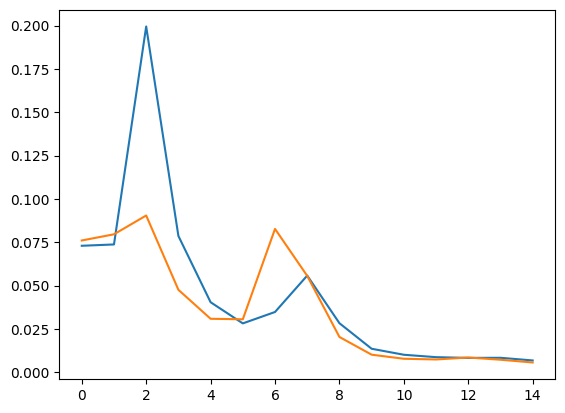

Save model dat1/model1_202307240932_15_cv8.ckpt
Save hist dat1/hist_202307240932_15_cv8.ckpt
fine tuning
datetime: 07/24 09:46


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
hist1_cv = []
hist2_cv = []

t_epoch1 = 15
t_epoch2 = 30

for cv in range(10):
    idx_val = idx_cv10[cv]
    idx_trn = np.setdiff1d(np.arange(n_sample), idx_val)

    hist1_cv.append(None)
    hist2_cv.append(None)

    path_load = "dat1/model1_{}_0.ckpt".format(stamp)
    model1.load_state_dict(torch.load(path_load))
    if(optimizer=="Adagrad"):
        optim1 = optim.Adagrad(model1.parameters(), lr=learning_rate)
    if(optimizer=="Adam"):
        optim1 = optim.Adam(model1.parameters(), lr=learning_rate, amsgrad=True)

    hist1_cv[cv] = train1(t_epoch1, 3)

    path_save = "dat1/model1_{}_{}_cv{}.ckpt".format(stamp, t_epoch1, cv)
    torch.save(model1.state_dict(), path_save)
    print("Save model", path_save)
    
    path_save = "dat1/hist_{}_{}_cv{}.ckpt".format(stamp, t_epoch1, cv)
    hist1_cv[cv].DataFrame().to_csv(path_save)
    print("Save hist", path_save)

    
    
    path_load = "dat1/model2_{}_0.ckpt".format(stamp)
    model2.load_state_dict(torch.load(path_load))
    if(optimizer=="Adagrad"):
        optim2 = optim.Adagrad(list(model1.parameters())+list(model2.parameters()), lr=learning_rate)

    if(optimizer=="Adam"):
        if(tuning=="model1+model2"):
            print("fine tuning")
            optim2 = optim.Adam(list(model1.parameters())+list(model2.parameters()), lr=learning_rate)
        if(tuning=="model2"):
            print("fixed encoder")
            optim2 = optim.Adam(model2.parameters(), lr=learning_rate, amsgrad=True)

    t_epoch2 = 60
    hist2_cv[cv] = train2(t_epoch2, 6)

    path_save = "dat1/model1_{}_{}_cv{}.ckpt".format(stamp, t_epoch1+t_epoch2, cv)
    torch.save(model1.state_dict(), path_save)
    print("Save model", path_save)

    path_save = "dat1/model2_{}_{}_cv{}.ckpt".format(stamp, t_epoch2, cv)
    torch.save(model2.state_dict(), path_save)
    print("Save model", path_save)
    
    path_save = "dat1/hist2_{}_{}_cv{}.ckpt".format(stamp, t_epoch2, cv)
    #print(hist2_cv[cv])
    hist2_cv[cv].DataFrame().to_csv(path_save)
    print("Save hist", path_save)


# Evaluation

In [ ]:
target_all_eval=np.load("dat1/target_all.npy")
target_1k_eval=np.load("dat1/target_1k.npy")

In [ ]:
stamp_load = "202211052103"
t0_1 = 75
t0_2 = 60

cv = 0
path_load = "dat1/model1_{}_{}_cv{}.ckpt".format(stamp_load, t0_1, cv)
model1.load_state_dict(torch.load(path_load))
path_load = "dat1/model2_{}_{}_cv{}.ckpt".format(stamp_load, t0_2, cv)
model2.load_state_dict(torch.load(path_load))


In [ ]:
batch_list = make_batch_list(np.arange(1000), batch_size=batch_size, shuffle=False)
idx_tmp = batch_list[0]
xxx_tmp, yyy_tmp = generate_batch(idx_tmp, pix_20210708, target_1k)
loss_embedding, zzz_tmp, out_tmp, perplexity = model1(xxx_tmp)

pix_src = xxx_tmp.detach().cpu().numpy()*255
pix_out = out_tmp.detach().cpu().numpy()*255

In [ ]:
plt.figure(figsize=(8,4))

#plt.subplot(1,2,1)
plt.imshow(pix_src[0,0],cmap="gray")
plt.axis("off")
# plt.savefig("fig1/img_src.png", bbox_inches="tight", pad_inches=0)
plt.show()
img_tmp = Image.fromarray(pix_src[0,0])
img_tmp = img_tmp.convert("L")
# img_tmp.save("fig1/img_src.png")

#plt.subplot(1,2,2)
plt.imshow(pix_out[0,0],cmap="gray")
plt.axis("off")
# plt.savefig("fig1/img_out.png", bbox_inches="tight", pad_inches=0)
plt.show()
img_tmp = Image.fromarray(pix_out[0,0])
img_tmp = img_tmp.convert("L")
# img_tmp.save("fig1/img_out.png")


In [ ]:
import pickle
target_type = "both"
print(target_type)
flag = {}

with open("dat1/flag.pkl", "rb") as tf:
    flag = pickle.load(tf)

In [ ]:
# key6 = ["000",("001","010"),"011","200",("201","210"),"211"]
key6 = ["00","01","02","20","21","22"]
label6 = {"00":"N,NN", 
          "01":"N,PN",
          "02":"N,PP",
          "20":"P,NN",
          "21":"P,PN",
          "22":"P,PP",
         }
p_hat = {}
p_hat["00"] = 1/6
p_hat["01"] = 2/6
p_hat["02"] = 3/6
p_hat["20"] = 3/8
p_hat["21"] = 4/7
p_hat["22"] = 7/9

p_hat6 = np.array([ p_hat[kk] for kk in key6 ])
idx_p6 = np.argsort(p_hat6)


In [ ]:
from sklearn import metrics
stamp_load = "202211052103"
t0_1 = 75
t0_2 = 60

prd_all = np.load(f"dat1/vqvae_{stamp_load}_prd_all.npy")
#Store the predicted probability of test data in each validation
prd_1k_cv = np.load(f"dat1/vqvae_{stamp_load}_prd_1k_cv.npy")

In [ ]:
from sklearn import metrics

# pleural
fpr, tpr, theta = metrics.roc_curve(target_all_eval[:,0], prd_all[:,0])
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.title("ROC Curve (Pleaural thickening)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.axis("equal")
plt.savefig("AUC_pleu.{}.pdf".format(stamp))
plt.show()
print("AUC=", metrics.auc(fpr,tpr))
ii = np.argmin(fpr - tpr)
print(theta[ii])
y_pred = prd_all[:,0] > theta[ii]
conf_p = metrics.confusion_matrix(1-target_all_eval[:,0], 1-y_pred)
print(conf_p)
print(np.round(conf_p/n_sample*100, 1))

# scoliosis
fpr, tpr, theta = metrics.roc_curve(target_all_eval[:,1], prd_all[:,1])
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr)
plt.title("ROC Curve (Scoliosis)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.axis("equal")
plt.savefig("AUC_scol.{}.pdf".format(stamp))
plt.show()
print("AUC=", metrics.auc(fpr,tpr))
ii = np.argmin(fpr - tpr)
print(theta[ii])
y_pred = prd_all[:,1] > theta[ii]
conf_s = metrics.confusion_matrix(1-target_all_eval[:,1], 1-y_pred)
print(conf_s)
print(np.round(conf_s/n_sample*100, 1))


In [ ]:
# pleural 
TP_p = conf_p[1,1]
FN_p = conf_p[1,0]
FP_p = conf_p[0,1]
TN_p = conf_p[0,0]

precision_p = TP_p / (TP_p + FP_p)
recall_p = TP_p / (TP_p + FN_p)
specificity_p = TN_p / (TN_p + FP_p)
F1_p = 2*recall_p*precision_p / (recall_p+precision_p)

accuracy_p = (TP_p + TN_p) / len(prd_all)
print("F1:\t\t", np.round(F1_p,3))
print("Precision:\t", np.round(precision_p,3))
print("Recall:\t\t",np.round(recall_p,3))
print("Specificity:\t",np.round(specificity_p,3))
print("Accuracy:\t", np.round(accuracy_p,3))

In [ ]:
# scoliosis
TP_s = conf_s[1,1]
FN_s = conf_s[1,0]
FP_s = conf_s[0,1]
TN_s = conf_s[0,0]

precision_s = TP_s / (TP_s + FP_s)
recall_s = TP_s / (TP_s + FN_s)
specificity_s = TN_s / (TN_s + FP_s)
F1_s = 2*recall_s*precision_s / (recall_s+precision_s)

accuracy_s = (TP_s + TN_s) / len(prd_all)
print("F1:\t\t", np.round(F1_s,3))
print("Precision:\t", np.round(precision_s,3))
print("Recall:\t\t",np.round(recall_s,3))
print("Specificity:\t",np.round(specificity_s,3))
print("Accuracy:\t", np.round(accuracy_s,3))

### Fitting logit density functions

Variable transformation of the posterior distribution into a function of logit.

The general form of the variable transformation of the density distribution can be expressed as follows : 

\begin{eqnarray}
p_x(u) &=& p(u(x)) \times \left| \frac{du}{dx}(x) \right| \\
  &=& p(u(x)) \times \left| \frac{1}{\frac{dx}{du}(u)} \right|
\end{eqnarray}

The relationship between logit and sigmoid can be expressed as follows : 

\begin{eqnarray}
u(x) &=& \log(x) - \log(1-x) \\
x(u) &=& \frac{1}{1+e^{-u}}
\end{eqnarray}

Using this, the function of the posterior distribution in the (N,NN) case can be expressed as follows : 

\begin{eqnarray}
p(x) &=& \frac{5}{1} (1-x)^4 \\
 &=& \frac{5}{1} (1-\frac{1}{1+e^{-u}})^4 \times x(1-x) \\
 &=& \frac{5}{1} (1-\frac{1}{1+e^{-u}})^4 \times \frac{e^{-u}}{(1+e^{-u})^2}
\end{eqnarray}




In [ ]:
def logit(ppp):
    return(np.log(ppp) - np.log(1-ppp))

def sigmoid(uuu):
    return(1/(1+np.exp(-uuu)))


In [ ]:
def posterior_p2(sigmoid_output, key):
    """
    Calulate posterior probabilities for output values of sigmoid functions.
    
    Arg:
        sigmoid_output(torch.Tensor) : The output of sigmoid function
        key(str) : The key for physician diagnosis type
    """
    yyy = sigmoid_output*0
    if(key == "22"):
        yyy = (sigmoid_output**4 + 2*(sigmoid_output**3)*(1-sigmoid_output))*10/3
    if(key == "21"):
        yyy = ((sigmoid_output**3)*(1-sigmoid_output) + 2*(sigmoid_output**2)*(1-sigmoid_output)**2)*60/7
    if(key == "20"):
        yyy = ((sigmoid_output**2)*(1-sigmoid_output)**2 + 2*sigmoid_output*(1-sigmoid_output)**3)*15/2
    if(key == "02"):
        yyy = ((sigmoid_output**2)*(1-sigmoid_output)**2)*30
    if(key == "01"):
        yyy = (sigmoid_output*(1-sigmoid_output)**3)*20
    if(key == "00"):
        yyy = ((1-sigmoid_output)**4)*5
    return(yyy)

def posterior_u2(logit, key):
    """
    Calulate posterior probabilities for output values of logit function.
    
    Arg:
        logit(torch.Tensor) : The output of logit function
        key(str) : The key for physician diagnosis type
    """
    xxx = sigmoid(logit)
    yyy = posterior_p2(xxx, key)*xxx*(1-xxx)
    return(yyy)

In [ ]:
uuu = np.linspace(-30,30,301)
for kk in key6:
    yyy = posterior_u2(uuu, kk)
    plt.plot(uuu,yyy)
plt.xlim(-10,10)
plt.show()


$$
\int p(u)du = \lim_{n \rightarrow \infty} \frac{L}{n} \sum p(u_i) = 1
$$

In [ ]:
#Comparison of theoretical values of a physician's diagnostic model assuming a Bernoulli process with the output of the model
kk = "22"
ll = 1.5
uuu = prd_1k_cv[:,flag["pleural"][kk],0]

dist_tmp = np.histogram(uuu*ll, density=True, bins=np.linspace(-30,30,101))
mids = (dist_tmp[1][1:] + dist_tmp[1][0:-1])/2
ppp = sigmoid(mids)

yyy = posterior_u2(mids, kk)
print(np.sum(yyy)*(30+30)/100)
print(np.sum(-yyy*np.log(dist_tmp[0]+1e-32)))
plt.plot(mids,yyy)
plt.plot(mids,dist_tmp[0])
plt.show()

In [ ]:
def loss_mse6(target, ll):
    # Function to compute the Mean Squared Error (MSE) loss for the given target and weights ll.
    loss_tmp = []
    for kk in key6:
        # Select the appropriate predictions based on the target ("pleural" or "scoliosis").
        if target == "pleural":
            uuu = prd_1k_cv[:, flag["pleural"][kk], 0]
        elif target == "scoliosis":
            uuu = prd_1k_cv[:, flag["scoliosis"][kk], 1]

        # Compute the histogram of uuu*ll and normalize it.
        dist_tmp = np.histogram(uuu * ll, density=True, bins=np.linspace(-30, 30, 101))
        mids = (dist_tmp[1][1:] + dist_tmp[1][0:-1]) / 2

        # Compute the posterior probabilities and calculate the squared difference from the histogram.
        ppp = sigmoid(mids)
        yyy = posterior_u2(mids, kk)
        loss_tmp.append((dist_tmp[0] - yyy) ** 2)

    # Concatenate the loss values for all keys and compute the mean loss.
    loss_tmp = np.concatenate(loss_tmp)
    return np.mean(loss_tmp)

def loss_kl6(target, ll):
    # Function to compute the Kullback-Leibler (KL) divergence loss for the given target and weights ll.
    loss_tmp = []
    epsilon = 1e-32
    for kk in key6:
        # Select the appropriate predictions based on the target ("pleural" or "scoliosis").
        if target == "pleural":
            uuu = prd_1k_cv[:, flag["pleural"][kk], 0]
        elif target == "scoliosis":
            uuu = prd_1k_cv[:, flag["scoliosis"][kk], 1]

        # Compute the histogram of uuu*ll and normalize it.
        dist_tmp = np.histogram(uuu * ll, density=True, bins=np.linspace(-30, 30, 101))
        mids = (dist_tmp[1][1:] + dist_tmp[1][0:-1]) / 2

        # Compute the posterior probabilities and calculate the KL divergence.
        ppp = sigmoid(mids)
        yyy = posterior_u2(mids, kk)
        kl = np.sum(-yyy * np.log(dist_tmp[0] + epsilon))
        loss_tmp.append(kl)

    # Convert the loss values to an array and compute the mean loss.
    loss_tmp = np.array(loss_tmp)
    return np.mean(loss_tmp)

In [ ]:
from scipy.optimize import minimize_scalar
lambda_mse_p = minimize_scalar(lambda ll: loss_mse6("pleural",ll), bounds=(0,2),method="bounded")
print("lambda_p =", lambda_mse_p["x"])
lambda_mse_s = minimize_scalar(lambda ll: loss_mse6("scoliosis",ll), bounds=(0,2), method="bounded")
print("lambda_s =", lambda_mse_s["x"])

In [ ]:
print(loss_mse6("scoliosis", lambda_mse_s["x"]))

In [ ]:
print(loss_mse6("pleural", lambda_mse_s["x"]))

In [ ]:
from scipy.optimize import minimize_scalar
lambda_kl_p = minimize_scalar(lambda ll: loss_kl6("pleural",ll), bounds=(0,2),method="bounded")
print("lambda_p =", lambda_kl_p["x"])
lambda_kl_s = minimize_scalar(lambda ll: loss_kl6("scoliosis",ll), bounds=(0,2), method="bounded")
print("lambda_s =", lambda_kl_s["x"])

In [ ]:
print(loss_kl6("scoliosis", lambda_kl_s["x"]))

In [ ]:
print(loss_kl6("pleural", lambda_kl_s["x"]))

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(prd_1k_cv[0,:,0],prd_1k_cv[1,:,0])
plt.scatter(prd_1k_cv[2,:,0],prd_1k_cv[3,:,0])
plt.scatter(prd_1k_cv[4,:,0],prd_1k_cv[5,:,0])
plt.scatter(prd_1k_cv[6,:,0],prd_1k_cv[7,:,0])
plt.scatter(prd_1k_cv[8,:,0],prd_1k_cv[9,:,0])
plt.axis("equal")
plt.show()

In [ ]:
rr_p = lambda_mse_p["x"]
prd_pleu_mean6 = []
for kk in key6:
    print(kk)
    plt.figure(figsize=(6,4))
    plt.title("Pleural thickening {}".format(label6[kk]))
    plt.xlabel("Logit")
    plt.ylabel("Density")
    tmp = prd_1k_cv[:,flag["pleural"][kk],0].reshape(-1)*rr_p
    plt.hist(tmp, density=True, bins=np.linspace(-30,30,101))
    xxx = np.linspace(-30,30,301)
    ppp = sigmoid(xxx)
    yyy = posterior_u2(xxx, kk)
    plt.plot(xxx,yyy, color="red")
    mean_tmp = np.mean(tmp)
    prd_pleu_mean6.append(mean_tmp)
    # plt.axvline(mean_tmp,0,100, color="blue", linestyle="dashed")
    plt.axvline(logit(p_hat[kk]),0,100, color="red", linestyle="dotted")
    plt.xlim((-10,10))
    plt.ylim((-0.01,0.5))
    plt.savefig("fig1/logit_dist_pleu_resnet50_{}.{}.pdf".format(kk,stamp), bbox_inches="tight", pad_inches=0.1)
    plt.show()

prd_pleu_mean6 = np.array(prd_pleu_mean6)
np.corrcoef(prd_pleu_mean6, p_hat6)


In [ ]:
rr_s = lambda_mse_s["x"]
prd_scol_median6 = []
prd_scol_mean6 = []
for kk in key6:
    print(kk)
    plt.figure(figsize=(6,4))
    plt.title("Scoliosis {}".format(label6[kk]))
    plt.xlabel("Logit")
    plt.ylabel("Density")
    tmp = prd_1k_cv[:,flag["scoliosis"][kk],1].reshape(-1)*rr_s
    plt.hist(tmp, density=True, bins=np.linspace(-30,30,101))
    xxx = np.linspace(-30,30,301)
    ppp = sigmoid(xxx)
    yyy = posterior_u2(xxx, kk)
    plt.plot(xxx,yyy, color="red")

    mean_tmp = np.mean(tmp)
    prd_scol_mean6.append(mean_tmp)
    median_tmp = np.median(tmp)
    prd_scol_median6.append(median_tmp)
    #plt.axvline(mean_tmp,0,100, color="blue", linestyle="dashed")
    #plt.axvline(median_tmp,0,100, color="blue", linestyle="dashed")
    plt.axvline(logit(p_hat[kk]),0,100, color="red", linestyle="dotted")
    plt.xlim((-10,10))
    plt.savefig("fig1/logit_dist_scol_resnet50_{}.{}.pdf".format(kk,stamp), bbox_inches="tight", pad_inches=0.1)
    plt.show()

prd_scol_mean6 = np.array(prd_scol_mean6)
print(np.corrcoef(prd_scol_mean6, p_hat6))
#prd_scol_median6 = np.array(prd_scol_median6)
#print(np.corrcoef(prd_scol_median6, p_hat6))


In [ ]:
hoge = []
fuga = []

for key_tmp in np.array(key6,dtype=object)[idx_p6]:
    tmp = sigmoid(prd_1k_cv[:,flag["pleural"][key_tmp],0].reshape(-1)*rr_p)
    hoge.append(tmp)
    fuga.append(np.mean(tmp))
plt.figure(figsize=(5,5))
plt.title("Pleural thickening")
plt.xlabel("Expected")
plt.ylabel("Output")
plt.xlim((-0.05,1.05))
plt.ylim((-0.05,1.05))
plt.boxplot(hoge, positions=p_hat6[idx_p6], widths=0.03, labels=["1/6","1/3","3/8","1/2","4/7","7/9",], sym="", medianprops=dict(color='black', linewidth=1))
plt.plot(p_hat6[idx_p6], fuga)
tmp = np.concatenate([[0], p_hat6, [1]])
plt.plot(tmp, tmp, color="gray", linestyle="dotted")
plt.savefig("fig1/corr_pleu.pdf", bbox_inches="tight", pad_inches=0.1)

plt.show()

print(fuga)
np.corrcoef(p_hat6[idx_p6], fuga)



In [ ]:
hoge = []
fuga = []
rr_s = 0.2165
for key_tmp in np.array(key6,dtype=object)[idx_p6]:
    tmp = sigmoid(prd_1k_cv[:,flag["scoliosis"][key_tmp],1].reshape(-1)*rr_s)
    hoge.append(tmp)
    fuga.append(np.mean(tmp))
plt.figure(figsize=(5,5))
plt.title("Scoliosis")
plt.xlabel("Expected")
plt.ylabel("Output")
plt.xlim((-0.05,1.05))
plt.ylim((-0.05,1.05))
plt.boxplot(hoge, positions=p_hat6[idx_p6], widths=0.03, labels=["1/6","1/3","3/8","1/2","4/7","7/9",], sym="", medianprops=dict(color='black', linewidth=1))
plt.plot(p_hat6[idx_p6], fuga)
tmp = np.concatenate([[0], p_hat6, [1]])
plt.plot(tmp, tmp, color="gray", linestyle="dotted")
plt.savefig("fig1/corr_scol.pdf", bbox_inches="tight", pad_inches=0.1)

plt.show()
print(fuga)
np.corrcoef(p_hat6[idx_p6], fuga)


### Validation 1K

$$
\int_0^1 x^m(1-x)^n = \frac{m!n!}{(m+n+1)!}
$$

$$
E_x[ p_{000}(x)] = \frac{\int_0^1 x(1-x)^4 }{\int_0^1 (1-x)^4} = \frac{4!}{6!} / \frac{4!}{5!} = \frac{1}{6}
$$

$$
E_x[ p_{001}(x)] = E_x[ p_{010}(x)] = \frac{\int_0^1 x^2(1-x)^3 }{\int_0^1 x(1-x)^3} = \frac{2!3!}{6!}/\frac{3!}{5!} = \frac{2}{6} = \frac{1}{3}
$$

$$
E_x[ p_{011}(x)] = \frac{\int_0^1 x^3(1-x)^2 }{\int_0^1 x^2(1-x)^2} = \frac{3!2!}{6!} / \frac{2!2!}{5!} = \frac{3}{6} = \frac{1}{2}
$$


$$
E_x[ p_{200}(x)] = \frac{\int_0^1 x(x^2(1-x)^2 + 2x(1-x)^3) }{\int_0^1  (x^2(1-x)^2 + 2x(1-x)^3)} = \frac{3!2!+2\times2!3!}{6!} / \frac{2!2!+2\times3!}{5!} =\frac{36}{6}\frac{1}{16} = \frac{3}{8}
$$

$$
E_x[ p_{201}(x)] = E_x[ p_{210}(x)] = \frac{\int_0^1 x(x^3(1-x)^1 + 2x^2(1-x)^2) }{\int_0^1 (x^3(1-x) + 2x^2(1-x)^2)} = \frac{4! + 2\times 3!2!}{6!}/\frac{3!+2\times2!2!}{5!} = \frac{48}{6}\frac{1}{14} = \frac{4}{7}
$$

$$
E_x[ p_{211}(x)] = \frac{\int_0^1 x(x^4 + 2x^3(1-x)) }{\int_0^1 x^4 + 2x^3(1-x)} = \frac{5! + 2\times 4!}{6!} / \frac{4! + 2\times 3!}{5!} = \frac{7\times 24}{6}\frac{1}{36} = \frac{7}{9}
$$
